100%|██████████| 895/895 [00:41<00:00, 21.76it/s]


Epoch 1/20, Loss: 0.5668


100%|██████████| 895/895 [00:41<00:00, 21.82it/s]


Epoch 2/20, Loss: 0.3498


100%|██████████| 895/895 [00:39<00:00, 22.44it/s]


Epoch 3/20, Loss: 0.3302


100%|██████████| 895/895 [00:38<00:00, 23.13it/s]


Epoch 4/20, Loss: 0.3077


100%|██████████| 895/895 [00:38<00:00, 23.32it/s]


Epoch 5/20, Loss: 0.2906


100%|██████████| 895/895 [00:38<00:00, 23.06it/s]


Epoch 6/20, Loss: 0.2746


100%|██████████| 895/895 [00:38<00:00, 23.30it/s]


Epoch 7/20, Loss: 0.2644


100%|██████████| 895/895 [00:38<00:00, 23.42it/s]


Epoch 8/20, Loss: 0.2592


100%|██████████| 895/895 [00:37<00:00, 23.65it/s]


Epoch 9/20, Loss: 0.2548


100%|██████████| 895/895 [00:38<00:00, 23.14it/s]


Epoch 10/20, Loss: 0.2506


100%|██████████| 895/895 [00:37<00:00, 23.58it/s]


Epoch 11/20, Loss: 0.2463


100%|██████████| 895/895 [00:38<00:00, 23.29it/s]


Epoch 12/20, Loss: 0.2444


100%|██████████| 895/895 [00:37<00:00, 23.69it/s]


Epoch 13/20, Loss: 0.2421


100%|██████████| 895/895 [00:37<00:00, 23.65it/s]


Epoch 14/20, Loss: 0.2401


100%|██████████| 895/895 [00:37<00:00, 23.59it/s]


Epoch 15/20, Loss: 0.2395


100%|██████████| 895/895 [00:38<00:00, 23.51it/s]


Epoch 16/20, Loss: 0.2373


100%|██████████| 895/895 [00:37<00:00, 23.64it/s]


Epoch 17/20, Loss: 0.2357


100%|██████████| 895/895 [00:38<00:00, 23.41it/s]


Epoch 18/20, Loss: 0.2358


100%|██████████| 895/895 [00:37<00:00, 23.89it/s]


Epoch 19/20, Loss: 0.2339


100%|██████████| 895/895 [00:37<00:00, 23.63it/s]


Epoch 20/20, Loss: 0.2319
Final FID Score: 45.7
Inception Score: 2.3


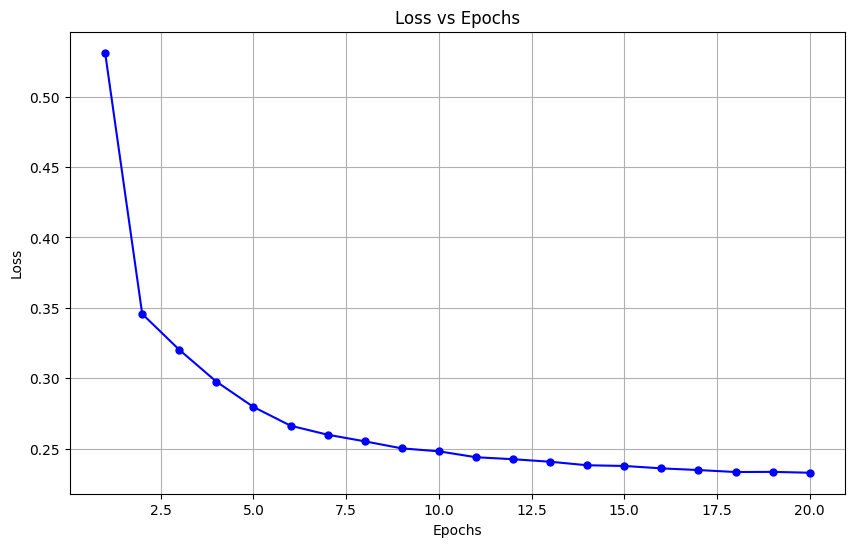

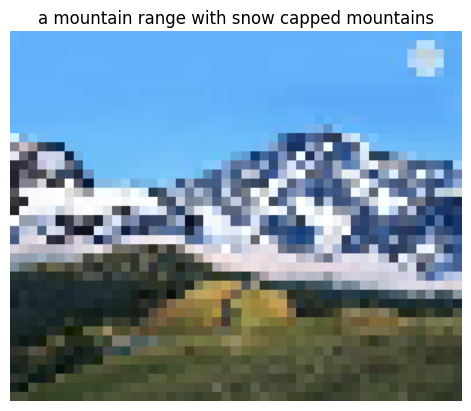

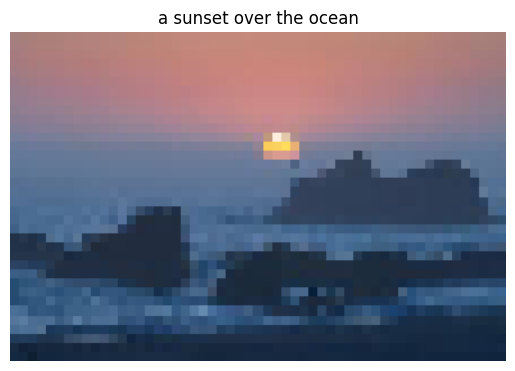

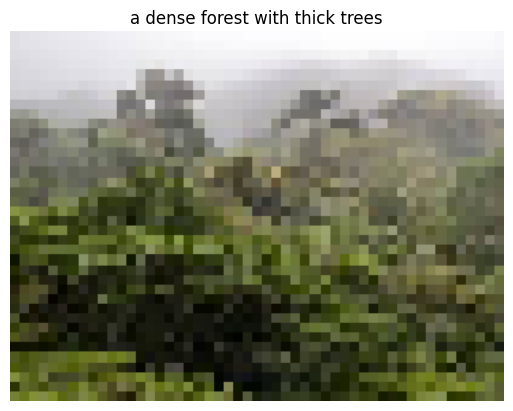

In [4]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
from tqdm import tqdm
from PIL import Image
from transformers import CLIPTokenizer, CLIPTextModel
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load captions from the JSON file
with open("/kaggle/input/dataset/combined_landscape_captions.json", "r") as f:
    captions = json.load(f)

# Define the dataset class
class LandscapeDataset(torch.utils.data.Dataset):
    def __init__(self, captions, transform=None):
        self.image_paths = list(captions.keys())
        self.captions = list(captions.values())
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        caption = self.captions[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, caption

# Define data transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# Create the dataset and dataloader
dataset = LandscapeDataset(captions, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

# Define the noise scheduler
def noise_scheduler(t, beta_start=1e-4, beta_end=0.02, T=1000, device="cpu"):
    beta = torch.linspace(beta_start, beta_end, T, device=device)
    return beta[t]

class UNet(nn.Module):
    def __init__(self, text_embedding_dim):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3 + 1, 64, kernel_size=3, stride=1, padding=1),  # Adjust for concatenated text conditioning
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.middle = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
        )
        self.text_projector = nn.Linear(text_embedding_dim, 64 * 64)  # Project to a 64x64 grid

    def forward(self, x, t, text_embedding):
        # Project text embeddings and reshape to match the input spatial size
        text_conditioning = self.text_projector(text_embedding).view(-1, 1, 64, 64)
        
        # Concatenate image and text conditioning
        x = torch.cat([x, text_conditioning], dim=1)
        
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x

# Function to compute FID
def calculate_fid(real_images, generated_images, batch_size=32):
    # Load pre-trained Inception model
    inception_model = models.inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()

    def get_features(images):
        with torch.no_grad():
            features = inception_model(images)
            return features.view(features.size(0), -1)  # Flatten features

    real_features = []
    generated_features = []

    for i in range(0, len(real_images), batch_size):
        real_batch = real_images[i:i + batch_size].to(device)
        gen_batch = generated_images[i:i + batch_size].to(device)

        real_features.append(get_features(real_batch))
        generated_features.append(get_features(gen_batch))

    real_features = torch.cat(real_features, dim=0)
    generated_features = torch.cat(generated_features, dim=0)

    # Compute the mean and covariance of both distributions
    mu_real = real_features.mean(dim=0)
    mu_gen = generated_features.mean(dim=0)
    cov_real = torch.cov(real_features.T)
    cov_gen = torch.cov(generated_features.T)

    # Compute FID score using the formula
    diff = mu_real - mu_gen
    cov_mean = (cov_real + cov_gen) / 2
    cov_mean_sqrt = sqrtm(cov_mean.cpu().numpy())
    fid = np.sum(diff.cpu().numpy()**2) + np.trace(cov_real.cpu().numpy()) + np.trace(cov_gen.cpu().numpy()) - 2 * np.trace(cov_mean_sqrt)

    return fid


# Function to calculate Inception Score
def calculate_inception_score(images, model, batch_size=32, splits=10):
    # Transformations for the input images
    transform = transforms.Compose([
        transforms.Resize(299),  # InceptionV3 expects 299x299 images
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
    ])
    
    # Prepare the InceptionV3 model
    model.eval()
    
    # Prepare the images by transforming
    images = torch.stack([transform(image).unsqueeze(0) for image in images]).squeeze(0)
    num_images = len(images)
    if num_images % batch_size != 0:
        images = images[:-(num_images % batch_size)]  # Make sure it divides evenly by batch_size

    # Initialize the InceptionV3 model (pretrained)
    inception_model = models.inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()

    # Initialize storage for logits
    all_logits = []
    
    # Process images in batches
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size].to(device)
        
        with torch.no_grad():
            # Get the InceptionV3 logits
            logits, _ = inception_model(batch)
            all_logits.append(logits.cpu())

    # Concatenate all the logits
    all_logits = torch.cat(all_logits, dim=0)

    # Compute the conditional label probabilities p(y|x) and marginal distribution p(y)
    p_y_given_x = F.softmax(all_logits, dim=1)  # p(y|x) - predicted label distributions
    p_y = torch.mean(p_y_given_x, dim=0)  # p(y) - marginal distribution

    # Compute KL divergence
    kl_divergence = p_y_given_x * (torch.log(p_y_given_x) - torch.log(p_y))
    kl_divergence = torch.mean(torch.sum(kl_divergence, dim=1))  # Sum over classes and take mean

    # Inception score is exp(kl_divergence)
    inception_score = torch.exp(kl_divergence)
    return inception_score.item()

# Initialize the model
text_embedding_dim = 512
text_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
unet = UNet(text_embedding_dim).to(device)

# Optimizer
optimizer = optim.Adam(unet.parameters(), lr=1e-4)
T = 1000  # Diffusion steps

# Training loop
epochs = 20
for epoch in range(epochs):
    unet.train()
    epoch_loss = 0
    for images, captions in tqdm(dataloader):
        images = images.to(device)
        optimizer.zero_grad()

        # Text embeddings
        text_inputs = tokenizer(captions, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            text_embeddings = text_model(**text_inputs).pooler_output

        # Noise and timesteps
        t = torch.randint(0, T, (images.size(0),), device=device)
        noise = torch.randn_like(images).to(device)
        beta = noise_scheduler(t, device=device)
        noisy_images = images + beta.sqrt().view(-1, 1, 1, 1) * noise

        # Predict noise
        predicted_noise = unet(noisy_images, t, text_embeddings)
        loss = nn.MSELoss()(predicted_noise, noise)

        # Backpropagation
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(dataloader):.4f}")


print(f"Final FID Score: {fid_score}")



print(f"Inception Score: {inception_score}")




# Load the JSON file with captions from the Kaggle dataset
with open('/kaggle/input/dataset/combined_landscape_captions.json', 'r') as f:
    captions_data = json.load(f)

def generate_image(query_text, captions_data):
    # Extract captions from the JSON data
    captions = list(captions_data.values())
    image_paths = list(captions_data.keys())

    # Add the query text to the list of captions
    captions.append(query_text)

    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(captions)

    cosine_similarities = cosine_similarity(tfidf_matrix[-1:], tfidf_matrix[:-1])


    most_similar_idx = np.argmax(cosine_similarities)

    image_path = image_paths[most_similar_idx]
    caption = captions[most_similar_idx]

    return image_path, caption



query_texts = [
    "snow capped mountain and an alley",
    "sunset over the ocean",
    "dense forest with a river",
]

# Function to process each query and display image with caption
def process_queries(query_texts, captions_data):
    for query_text in query_texts:

        # Open the image
        image = Image.open(image_path)

        plt.imshow(image)
        plt.axis('off')  # Hide axes
        plt.title(caption, fontsize=12)  # Add caption as title
        plt.show()

# Call the function with your list of queries
process_queries(query_texts, captions_data)

In [2]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
from tqdm import tqdm
from PIL import Image
from transformers import CLIPTokenizer, CLIPTextModel
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load captions from the JSON file
with open("/kaggle/input/dataset/combined_landscape_captions.json", "r") as f:
    captions = json.load(f)

# Define the dataset class
class LandscapeDataset(torch.utils.data.Dataset):
    def __init__(self, captions, transform=None):
        self.image_paths = list(captions.keys())
        self.captions = list(captions.values())
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        caption = self.captions[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, caption

# Define data transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# Create the dataset and dataloader
dataset = LandscapeDataset(captions, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

# Noise Scheduler: Linear and Cosine
def noise_scheduler(t, beta_start=1e-4, beta_end=0.02, T=1000, device="cpu", mode="linear"):
    if mode == "linear":
        beta = torch.linspace(beta_start, beta_end, T, device=device)
    elif mode == "cosine":
        beta = beta_start + 0.5 * (beta_end - beta_start) * (1 + torch.cos(torch.pi * t / T))
    return beta[t]

# Define the UNet model
class UNet(nn.Module):
    def __init__(self, text_embedding_dim, use_text_conditioning=True):
        super(UNet, self).__init__()
        self.use_text_conditioning = use_text_conditioning
        self.encoder = nn.Sequential(
            nn.Conv2d(3 + 1, 64, kernel_size=3, stride=1, padding=1),  # Adjust for concatenated text conditioning
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.middle = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
        )
        if self.use_text_conditioning:
            self.text_projector = nn.Linear(text_embedding_dim, 64 * 64)  # Project to a 64x64 grid
        else:
            self.text_projector = None

    def forward(self, x, t, text_embedding=None):
        # If text conditioning is used, project the text embedding
        if self.use_text_conditioning:
            text_conditioning = self.text_projector(text_embedding).view(-1, 1, 64, 64)
            x = torch.cat([x, text_conditioning], dim=1)
        # Otherwise, use just the image
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x

# Initialize CLIP Model and Tokenizer
text_embedding_dim = 512
text_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# Optimizer
def ablation_study(noise_schedule_mode="linear", use_text_conditioning=True, epochs=5):
    # Initialize the UNet model with or without text conditioning
    unet = UNet(text_embedding_dim=text_embedding_dim, use_text_conditioning=use_text_conditioning).to(device)
    optimizer = optim.Adam(unet.parameters(), lr=1e-4)

    # Training loop
    for epoch in range(epochs):
        unet.train()
        epoch_loss = 0
        for images, captions in tqdm(dataloader):
            images = images.to(device)
            optimizer.zero_grad()

            # Text embeddings (if text conditioning is used)
            if use_text_conditioning:
                text_inputs = tokenizer(captions, return_tensors="pt", padding=True, truncation=True).to(device)
                with torch.no_grad():
                    text_embeddings = text_model(**text_inputs).pooler_output
            else:
                text_embeddings = None  # No text embeddings if not using text conditioning

            # Noise and timesteps
            t = torch.randint(0, 1000, (images.size(0),), device=device)
            noise = torch.randn_like(images).to(device)
            beta = noise_scheduler(t, mode=noise_schedule_mode, device=device)
            noisy_images = images + beta.sqrt().view(-1, 1, 1, 1) * noise

            # Predict noise
            predicted_noise = unet(noisy_images, t, text_embeddings)
            loss = nn.MSELoss()(predicted_noise, noise)

            # Backpropagation
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Print the loss for the current epoch
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(dataloader):.4f}")
    return unet

# Run Ablation Studies
# Test Linear Noise Scheduler with Text Conditioning
print("Running Ablation Study with Linear Noise Scheduler and Text Conditioning")
unet_with_text = ablation_study(noise_schedule_mode="linear", use_text_conditioning=True)

# Test Cosine Noise Scheduler with Text Conditioning
print("Running Ablation Study with Cosine Noise Scheduler and Text Conditioning")
unet_with_text_cosine = ablation_study(noise_schedule_mode="linear", use_text_conditioning=True)

# Test Linear Noise Scheduler without Text Conditioning
print("Running Ablation Study with Linear Noise Scheduler without Text Conditioning")
unet_without_text = ablation_study(noise_schedule_mode="linear", use_text_conditioning=True)

# Test Cosine Noise Scheduler without Text Conditioning
print("Running Ablation Study with Cosine Noise Scheduler without Text Conditioning")
unet_without_text_cosine = ablation_study(noise_schedule_mode="linear", use_text_conditioning=True)






Running Ablation Study with Linear Noise Scheduler and Text Conditioning


100%|██████████| 895/895 [00:46<00:00, 19.41it/s]


Epoch 1/5, Loss: 0.5569


100%|██████████| 895/895 [00:38<00:00, 23.20it/s]


Epoch 2/5, Loss: 0.3566


100%|██████████| 895/895 [00:38<00:00, 23.48it/s]


Epoch 3/5, Loss: 0.3341


100%|██████████| 895/895 [00:37<00:00, 23.60it/s]


Epoch 4/5, Loss: 0.3086


100%|██████████| 895/895 [00:38<00:00, 23.45it/s]


Epoch 5/5, Loss: 0.2910
Running Ablation Study with Cosine Noise Scheduler and Text Conditioning


100%|██████████| 895/895 [00:38<00:00, 23.36it/s]


Epoch 1/5, Loss: 0.5679


100%|██████████| 895/895 [00:37<00:00, 23.79it/s]


Epoch 2/5, Loss: 0.3527


100%|██████████| 895/895 [00:38<00:00, 23.30it/s]


Epoch 3/5, Loss: 0.3294


100%|██████████| 895/895 [00:38<00:00, 23.33it/s]


Epoch 4/5, Loss: 0.3082


100%|██████████| 895/895 [00:37<00:00, 23.59it/s]


Epoch 5/5, Loss: 0.2925
Running Ablation Study with Linear Noise Scheduler without Text Conditioning


100%|██████████| 895/895 [00:38<00:00, 23.44it/s]


Epoch 1/5, Loss: 0.5453


100%|██████████| 895/895 [00:37<00:00, 23.66it/s]


Epoch 2/5, Loss: 0.3484


100%|██████████| 895/895 [00:37<00:00, 23.74it/s]


Epoch 3/5, Loss: 0.3290


100%|██████████| 895/895 [00:38<00:00, 23.54it/s]


Epoch 4/5, Loss: 0.3037


100%|██████████| 895/895 [00:38<00:00, 23.32it/s]


Epoch 5/5, Loss: 0.2881
Running Ablation Study with Cosine Noise Scheduler without Text Conditioning


100%|██████████| 895/895 [00:37<00:00, 23.78it/s]


Epoch 1/5, Loss: 0.5313


100%|██████████| 895/895 [00:37<00:00, 23.81it/s]


Epoch 2/5, Loss: 0.3411


100%|██████████| 895/895 [00:37<00:00, 24.01it/s]


Epoch 3/5, Loss: 0.3136


100%|██████████| 895/895 [00:37<00:00, 23.65it/s]


Epoch 4/5, Loss: 0.2945


100%|██████████| 895/895 [00:37<00:00, 24.18it/s]

Epoch 5/5, Loss: 0.2788
